In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import re
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras import Sequential
from keras import Input as Kinput

Using TensorFlow backend.


In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib
device_lib.list_local_devices(), tf.test.gpu_device_name()

([name: "/device:CPU:0"
  device_type: "CPU"
  memory_limit: 268435456
  locality {
  }
  incarnation: 10190794664373272416, name: "/device:XLA_CPU:0"
  device_type: "XLA_CPU"
  memory_limit: 17179869184
  locality {
  }
  incarnation: 10531552123575437519
  physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
  device_type: "XLA_GPU"
  memory_limit: 17179869184
  locality {
  }
  incarnation: 7297575573593415528
  physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
  device_type: "GPU"
  memory_limit: 11150726272
  locality {
    bus_id: 1
    links {
    }
  }
  incarnation: 3751403171817362738
  physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"],
 '/device:GPU:0')

In [4]:
pd.options.display.max_colwidth = 200

In [5]:
df = pd.read_csv("/content/drive/My Drive/data/insincereQuora/train.csv")

In [6]:
df.shape

(1306122, 3)

In [7]:
df['target'].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

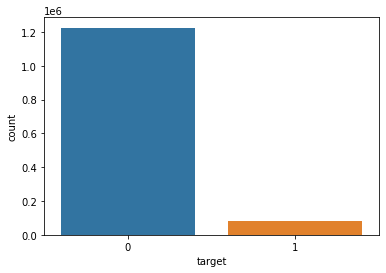

In [8]:
sns.countplot(x='target', data=df)

In [ ]:
df[df['target'] == 1]['question_text']

22                                                                                                                                             Has the United States become the largest dictatorship in the world?
30                                                                                                                          Which babies are more sweeter to their parents? Dark skin babies or light skin babies?
110                                                                                                         If blacks support school choice and mandatory sentencing for criminals why don't they vote Republican?
114                                                                      I am gay boy and I love my cousin (boy). He is sexy, but I dont know what to do. He is hot, and I want to see his di**. What should I do?
115                                                                                                                                                         

In [ ]:
df[df['target'] == 0]['question_text']

0                               How did Quebec nationalists see their province as a nation in the 1960s?
1                      Do you have an adopted dog, how would you encourage people to adopt and not shop?
2                                    Why does velocity affect time? Does velocity affect space geometry?
3                                              How did Otto von Guericke used the Magdeburg hemispheres?
4                          Can I convert montra helicon D to a mountain bike by just changing the tyres?
                                                       ...                                              
1306117    What other technical skills do you need as a computer science undergrad other than c and c++?
1306118      Does MS in ECE have good job prospects in USA or like India there are more IT jobs present?
1306119                                                                        Is foam insulation toxic?
1306120                          How can one start a re

In [ ]:
def count_stops(text):
  count = 0
  for letter in text:
    if letter in [',', '.', '?']:
      count+=1
  return count

In [ ]:
df['num_stops_comma_qmark'] = df['question_text'].apply(count_stops)

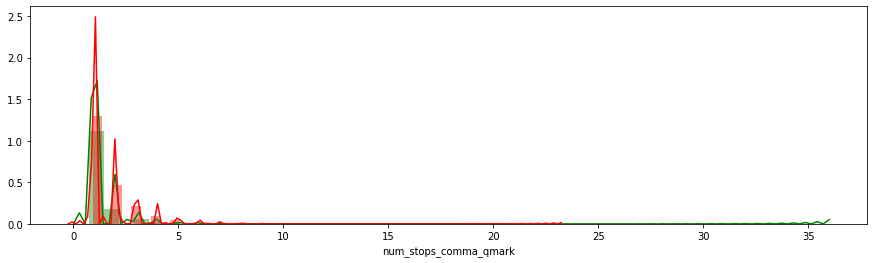

In [ ]:
plt.figure(figsize=(15,4))
sns.distplot(df['num_stops_comma_qmark'][df['target'] == 0],  color='green')
sns.distplot(df['num_stops_comma_qmark'][df['target'] == 1],  color='red'); 

In [ ]:
df['question_length'] = df['question_text'].str.len()

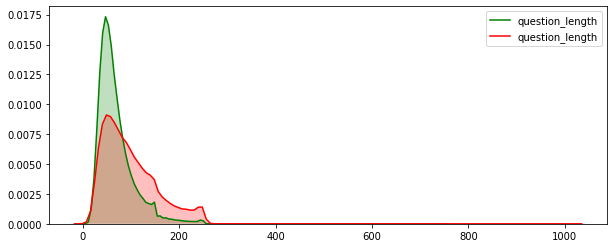

In [ ]:
plt.figure(figsize=(10,4))
sns.kdeplot(df['question_length'][df['target'] == 0], shade=1, color='green')
sns.kdeplot(df['question_length'][df['target'] == 1], shade=1, color='red'); 

In [ ]:
def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    # text = text.split()

    return text

In [ ]:
df['question_text'] = df['question_text'].apply(text_to_word_list)

In [ ]:
df['num_words'] = df['question_text'].apply(lambda x: len(x.split()))

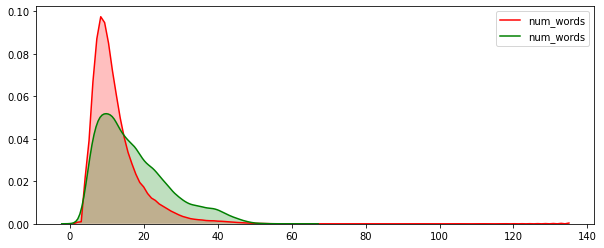

In [ ]:
plt.figure(figsize=(10,4))
sns.kdeplot(df['num_words'][df['target'] == 0], shade=1, color='red')
sns.kdeplot(df['num_words'][df['target'] == 1], shade=1, color='green'); 

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.20, random_state=2018)

In [ ]:
# df_train, df_valid = train_test_split(df_train, test_size=0.10, random_state=2018)

In [ ]:
max_length = 100
embed_size = 300
max_vocab_size = 50000

In [ ]:
train = df_train["question_text"].fillna("_na_").values
test = df_test["question_text"].fillna("_na_").values
# valid = df_valid["question_text"].fillna("_na_").values

In [ ]:
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(list(train))

In [ ]:
train_X = tokenizer.texts_to_sequences(train)
test_X = tokenizer.texts_to_sequences(test)
# valid_X = tokenizer.texts_to_sequences(valid)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=max_length)
test_X = pad_sequences(test_X, maxlen=max_length)
# valid_X = pad_sequences(valid_X, maxlen=max_length)

## Get the target values
train_y = df_train['target'].values
test_y = df_test['target'].values
# valid_y = df_valid['target'].values

In [ ]:
inp = Input(shape=(max_length,))
x = Embedding(max_vocab_size, embed_size)(inp)
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          140160    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17  

In [ ]:
model.fit(train_X, train_y, batch_size=2048, epochs=2, validation_data=(test_X, test_y))

Train on 1044897 samples, validate on 261225 samples
Epoch 1/2
1044897/1044897 [==============================] - 1080s 1ms/step - loss: 0.1313 - accuracy: 0.9507 - val_loss: 0.1087 - val_accuracy: 0.9557
Epoch 2/2
1044897/1044897 [==============================] - 1072s 1ms/step - loss: 0.1067 - accuracy: 0.9573 - val_loss: 0.1073 - val_accuracy: 0.9574


In [ ]:
pred_prob = model.predict([test_X], batch_size=2048, verbose=1)
max_acc = 0
at_thresh = 0
for thresh in np.arange(0.1, 0.701, 0.01):
    thresh = np.round(thresh, 2)
    acc = metrics.f1_score(test_y, (pred_prob>thresh).astype(int))
    if acc > max_acc:
      max_acc = acc
      at_thresh = thresh
print(" Max F1 score is {0} found at threshold {1}".format(max_acc, at_thresh))

261225/261225 [==============================] - 47s 181us/step
 Max F1 score is 0.654288586106768 found at threshold 0.654288586106768


In [ ]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-07-03 17:19:13--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.32.246
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.32.246|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  32.6MB/s    in 49s     

2020-07-03 17:20:02 (32.3 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
# !pip install gensim
from gensim.models import KeyedVectors

In [ ]:
EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz' # from above
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
# lower down
# remove punctutations
# take ensemble of models
# try lstm, gru
# try conv layer after lstm / gru


In [ ]:
word_index = tokenizer.word_index
nb_words = min(max_vocab_size, len(word_index))
embedding_matrix = np.random.normal(0, 1, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_vocab_size: continue
    if word in word2vec.vocab:  
      embedding_vector = word2vec[word]
    else:
      embedding_vector = None
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [ ]:
inp = Input(shape=(max_length,))
x = Embedding(max_vocab_size, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100, 128)          140160    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17  

In [ ]:
model.fit(train_X, train_y, batch_size=2048, epochs=2, validation_data=(test_X, test_y))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1044897 samples, validate on 261225 samples
Epoch 1/2
1044897/1044897 [==============================] - 425s 407us/step - loss: 0.1367 - accuracy: 0.9470 - val_loss: 0.1082 - val_accuracy: 0.9564
Epoch 2/2
1044897/1044897 [==============================] - 419s 401us/step - loss: 0.1032 - accuracy: 0.9584 - val_loss: 0.1048 - val_accuracy: 0.9577


In [ ]:
pred_prob = model.predict([test_X], batch_size=2048, verbose=1)
max_acc = 0
at_thresh = 0
for thresh in np.arange(0.1, 0.701, 0.01):
    thresh = np.round(thresh, 2)
    acc = metrics.f1_score(test_y, (pred_prob>thresh).astype(int))
    if acc > max_acc:
      max_acc = acc
      at_thresh = thresh
print(" Max F1 score is {0} found at threshold {1}".format(max_acc, at_thresh))

261225/261225 [==============================] - 20s 75us/step
 Max F1 score is 0.657105092944121 found at threshold 0.657105092944121


In [ ]:
model = Sequential()
model.add(Embedding(max_vocab_size, embed_size, input_length = max_length, weights=[embedding_matrix]))
# Bidirectional(GRU(64, return_sequences=True))
model.add(Bidirectional(LSTM(64, return_sequences=True, dropout_U = 0.2, dropout_W = 0.2)))  # returns a sequence of vectors of dimension 32
model.add(Bidirectional(LSTM(64, return_sequences=True, dropout_U = 0.2, dropout_W = 0.2)))  # returns a sequence of vectors of dimension 32
model.add(Bidirectional(LSTM(64, return_sequences=True, dropout_U = 0.2, dropout_W = 0.2)))  # return a single vector of dimension 32
model.add(GlobalMaxPool1D())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)`
  


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 100, 128)          186880    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 100, 128)          98816     
_________________________________________________________________
bidirectional_8 (Bidirection (None, 100, 128)          98816     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)              

In [ ]:
model.fit(train_X, train_y, batch_size=2048, epochs=2, validation_data=(test_X, test_y))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1044897 samples, validate on 261225 samples
Epoch 1/2
1044897/1044897 [==============================] - 1059s 1ms/step - loss: 0.1361 - accuracy: 0.9474 - val_loss: 0.1094 - val_accuracy: 0.9558
Epoch 2/2
1044897/1044897 [==============================] - 1058s 1ms/step - loss: 0.1084 - accuracy: 0.9554 - val_loss: 0.1062 - val_accuracy: 0.9568


In [ ]:
pred_prob = model.predict([test_X], batch_size=2048, verbose=1)
max_acc = 0
at_thresh = 0
for thresh in np.arange(0.1, 0.701, 0.01):
    thresh = np.round(thresh, 2)
    acc = metrics.f1_score(test_y, (pred_prob>thresh).astype(int))
    if acc > max_acc:
      max_acc = acc
      at_thresh = thresh
print(" Max F1 score is {0} found at threshold {1}".format(max_acc, at_thresh))

261225/261225 [==============================] - 48s 183us/step
 Max F1 score is 0.6519388407650718 found at threshold 0.6519388407650718
